### k-means法

ランダムなデータ点を生成

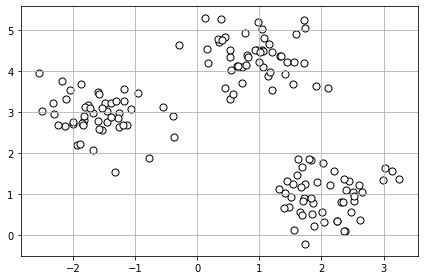

In [14]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', edgecolors='black', s=50)
plt.grid()
plt.tight_layout()
plt.show()

k-means法を適用させてみる

In [15]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

In [2]:
1e-04

0.0001

k-meansで作成されたクラスタと各クラスタのセントロイドをプロットしてみる

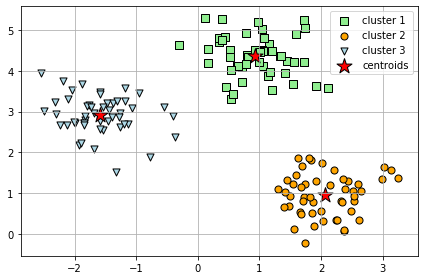

In [16]:
plt.scatter(X[y_km==0, 0],
            X[y_km==0, 1],
            s=50,
            c='lightgreen',
            edgecolors='black',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km==1, 0],
            X[y_km==1, 1],
            s=50,
            c='orange',
            edgecolors='black',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km==2, 0],
            X[y_km==2, 1],
            s=50,
            c='lightblue',
            edgecolors='black',
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:,0],
            km.cluster_centers_[:,1],
            s=250,
            marker='*',
            c='red',
            edgecolors='black',
            label='centroids')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

In [8]:
X[y_km==0, 0]

array([ 0.5323772 ,  0.802314  ,  0.5285368 ,  1.59141542,  1.74265969,
        1.72039618,  0.72144399,  0.16117091,  0.64003985,  1.13280393,
        1.04829186,  1.2091013 ,  0.3498724 ,  0.65910903,  1.15445328,
        0.34102758,  2.11114739,  1.45131429,  0.44089377,  1.08040757,
        0.72086751,  1.34081536,  1.06498315,  1.03972612, -0.30022483,
        0.12313498,  1.54597042,  0.38970838,  0.82049381,  1.56565986,
        0.96217896,  0.4519936 ,  1.19820169,  0.99914934,  0.77468161,
        1.91784543,  1.05374379,  1.72330962,  0.92466065,  0.39369516,
        0.78260667,  0.98152009,  1.00952869,  1.40848818,  0.5408715 ,
        0.5226209 ,  0.16932115,  0.56969694,  1.35678894,  1.1774409 ])

### クラスタリングの評価法

くらす内誤差平方和を使って、さまざまなk-meansクラスタリングの性能を評価する

In [17]:
# クラスタ内誤差平方和
print("Distortion: {:.3f}".format(km.inertia_))

Distortion: 72.476


これを見ることで、クラスタの個数を決定できる

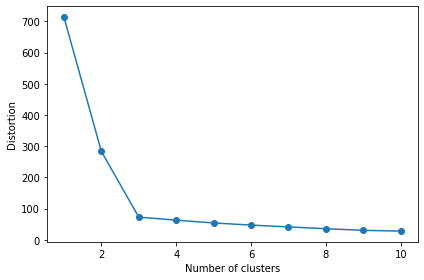

In [18]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

もう一個の方法が、シルエット図

In [24]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

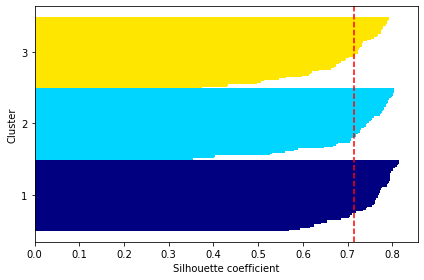

In [25]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

# シルエット係数を計算
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i)/ n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

In [26]:
cluster_labels = np.unique(y_km)
cluster_labels

array([0, 1, 2], dtype=int32)

In [32]:
n_clusters = cluster_labels.shape[0]
n_clusters

3

### クラスタリングの手法その2：　階層木

階層型・凝集・完全連結法をやってみる

サンプルデータの生成

In [35]:
import pandas as pd
import numpy as np
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [37]:
# 距離行列を計算
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [38]:
pdist(df, metric='euclidean')

array([4.973534  , 5.51665266, 5.89988504, 3.83539555, 4.34707339,
       5.10431109, 6.69823298, 7.24426159, 8.31659367, 4.382864  ])

In [41]:
squareform(pdist(df, metric='euclidean'))

array([[0.        , 4.973534  , 5.51665266, 5.89988504, 3.83539555],
       [4.973534  , 0.        , 4.34707339, 5.10431109, 6.69823298],
       [5.51665266, 4.34707339, 0.        , 7.24426159, 8.31659367],
       [5.89988504, 5.10431109, 7.24426159, 0.        , 4.382864  ],
       [3.83539555, 6.69823298, 8.31659367, 4.382864  , 0.        ]])

In [43]:
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
row_clusters

array([[0.        , 4.        , 3.83539555, 2.        ],
       [1.        , 2.        , 4.34707339, 2.        ],
       [3.        , 5.        , 5.89988504, 3.        ],
       [6.        , 7.        , 8.31659367, 5.        ]])

In [50]:
pd.DataFrame(row_clusters,
             columns=['row label 1',
                      'row label 2',
                      'distance',
                      'no. of items inclust.'])

,row label 1,row label 2,distance,no. of items inclust.
0,0.0,4.0,3.835396,2.0
1,1.0,2.0,4.347073,2.0
2,3.0,5.0,5.899885,3.0
3,6.0,7.0,8.316594,5.0


この結果を樹形図で見てみる

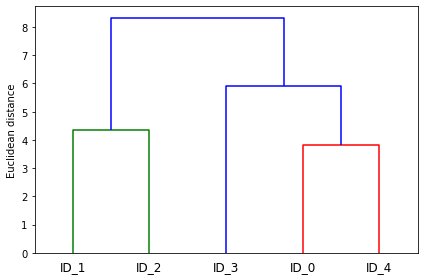

In [51]:
from scipy.cluster.hierarchy import dendrogram

row_dendr = dendrogram(row_clusters,
                       labels=labels,
                       )

plt.ylabel('Euclidean distance')
plt.tight_layout()
plt.show()

### DBSCAN

データセットの作成

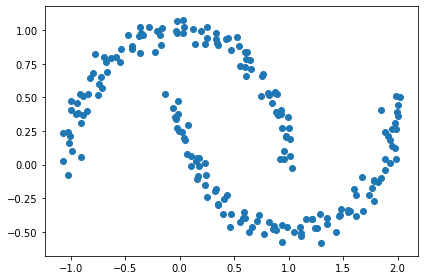

In [52]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200,
                  noise=0.05,
                  random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.tight_layout()
plt.show()